In [1]:
import numpy as np
import operator

from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import LeNet

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.backends.backend_pdf
import matplotlib.cm as cm

import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE

import entropy_estimator

from sklearn import cluster
from sklearn import mixture
from sklearn.cluster import DBSCAN

import pandas as pd
import seaborn as sn

import interval_utils

import knockpy
from knockpy.knockoff_filter import KnockoffFilter

from pyitlib import discrete_random_variable as drv

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/minhvu/myroot/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 400
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 2

In [3]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

train_dataset.targets[train_dataset.targets % 5 == 0] = 0
train_dataset.targets[train_dataset.targets % 5 != 0] = 1

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

valid_dataset.targets[valid_dataset.targets % 5 == 0] = 0
valid_dataset.targets[valid_dataset.targets % 5 != 0] = 1

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [4]:
SAVE_PATH = 'trained_model/mnist_mod_5'
model = LeNet.LeNet5(N_CLASSES)
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [5]:
sample_idx = 2
ROW_IMG = 4
N_ROWS = 3

OFF_SET = 10

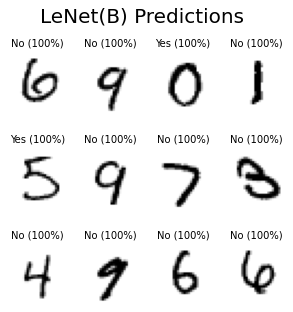

In [10]:
pred_to_label = {0: 'Yes', 1: 'No'}

fig = plt.figure(figsize = (5,5))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index+OFF_SET], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        y_hat = model(valid_dataset[index+OFF_SET][0].unsqueeze(0))
        probs = F.softmax(y_hat, dim=1)
        
    title = pred_to_label[torch.argmax(probs).item()] + " " + f'({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=10)
fig.suptitle('LeNet(B) Predictions', fontsize = 20);

In [11]:
import shap

bg_img = valid_dataset[0][0].unsqueeze(0).clone()
bg_num = 200

for index in range(1, bg_num - 1):
    bg_img = bg_img + valid_dataset[index][0].unsqueeze(0).clone()

bg_img = bg_img/bg_num

shapEx = shap.DeepExplainer(model,bg_img)

# shap_values = shapEx.shap_values(valid_dataset[0][0].unsqueeze(0))

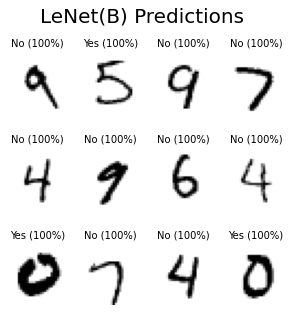

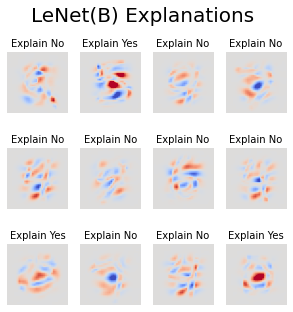

In [12]:
img_index = [3,7,15,16,
            17,19,20,21,
            24,25, 26,27,28]

fig = plt.figure(figsize = (5,5))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[img_index[index]], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        y_hat = model(valid_dataset[img_index[index]][0].unsqueeze(0))
        probs = F.softmax(y_hat, dim=1)
        
    title = pred_to_label[torch.argmax(probs).item()] + " " + f'({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=10)
fig.suptitle('LeNet(B) Predictions', fontsize = 20);

fig = plt.figure(figsize = (5,5))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    
    with torch.no_grad():
        model.eval()
        y_hat = model(valid_dataset[img_index[index]][0].unsqueeze(0))
        probs = F.softmax(y_hat, dim=1)
        pred_label = torch.argmax(probs).item()
    
    shap_values = shapEx.shap_values(valid_dataset[img_index[index]][0].unsqueeze(0))
    title = "Explain " + pred_to_label[torch.argmax(probs).item()]
    plt.imshow(shap_values[pred_label][0][0], cmap='coolwarm', vmin = -0.5, vmax = 0.5)
    plt.title(title, fontsize=10)
fig.suptitle('LeNet(B) Explanations', fontsize = 20);

In [13]:
# Hook
main_layers = []
for item in model._modules.items():
    main_layers.append(item[0])
    
activation = {}
def get_activation(name):
    def hook(model, input, output_):
        activation[name] = output_.detach()
    return hook

def get_activations(model_, input_):
    for main_layer in main_layers:
        for layer_index in range(len(getattr(model, main_layer))):
            getattr(model, main_layer)[layer_index].register_forward_hook(get_activation(main_layer + "_" + str(layer_index)))
    activation = {}
    with torch.no_grad():
        model_output = model_(input_)
        
def dict_activation(model_, input_):
    get_activations(model_, input_)
    act_ = {}
    act_ = activation.copy()
#     act_['Input'] = input_.unsqueeze(0)
    return act_

In [14]:
for i, (X,y) in enumerate(valid_loader):
    
    act_X = dict_activation(model, X)
    act_L = {}
    act_U = {}
    for key in act_X.keys():
        act_L[key] = torch.min(act_X[key], dim = 0).values[None]
        act_U[key] = torch.max(act_X[key], dim = 0).values[None]
    break

for i, (X,y) in enumerate(valid_loader):
    if i > 100:
        break
    else:
        act_X = dict_activation(model, X)
        act_l = {}
        act_u = {}
        for key in act_X.keys():
            act_l[key] = torch.min(act_X[key], dim = 0).values[None]
            act_u[key] = torch.max(act_X[key], dim = 0).values[None]
        act_L = interval_utils.min_units(act_l, act_L)
        act_U = interval_utils.max_units(act_u, act_U)

In [15]:
TEST_CLASS = [0,1]

NUMBER_BATCH = 4000

def get_class_activation(model_, X_, y_, layers_):
    act_X = dict_activation(model_, X_)
    X_class = X.clone()
    acts_ = {}
    for layer_ in layers_:
        acts_[layer_] = act_X[str(layer_)].clone()  
    return X_class, acts_

probe_layers = ['feature_extractor_4', 'feature_extractor_7', 'classifier_1', 'classifier_2']

for i, (X,y) in enumerate(valid_loader):
    if i == 0:
        X_, act_ = get_class_activation(model, X.to(DEVICE), y.to(DEVICE), probe_layers)
        y_ = y.clone()
    elif i < NUMBER_BATCH:
        X__, act__ = get_class_activation(model, X.to(DEVICE), y.to(DEVICE), probe_layers)
        X_ = torch.cat((X_, X__))
        y_ = torch.cat((y_, y.clone()))
        for layer in probe_layers:
            act_[layer] = torch.cat((act_[layer],act__[layer]))
    else:
        break

for layer in probe_layers:
    act_[layer] = act_[layer].reshape(act_[layer].shape[0],-1)

In [18]:
df_f1 = pd.DataFrame(data=np.array(act_['feature_extractor_4'].cpu()))
df_f2 = pd.DataFrame(data=np.array(act_['feature_extractor_7'].cpu()))
df_c1 = pd.DataFrame(data=np.array(act_['classifier_1'].cpu()))
df_c2 = pd.DataFrame(data=np.array(act_['classifier_2'].cpu()))

df_c2['pred'] = np.where(df_c2[0] > df_c2[1], 0, 1)

df_all = [df_f1[df_c2['pred'] == 0], df_f2[df_c2['pred'] == 0], 
          df_c1[df_c2['pred'] == 0], df_c2[df_c2['pred'] == 0]]

In [19]:
number_of_agglo_feats = [5, 5, 5]

top_neurons = {}

index_to_layer_name = dict(zip(range(len(number_of_agglo_feats)),
                              probe_layers[0:3]))

for frame_index in range(len(df_all)-1):

    X_var = np.array(df_all[frame_index])
    y_var = np.array(df_all[3])

    kfilter = KnockoffFilter(ksampler='gaussian', fstat='lasso')
    rejections = kfilter.forward(X=X_var, y=y_var[:,1], fdr=0.05)
    top_neurons[index_to_layer_name[frame_index]] = np.where(rejections==1)[0]

#     print(top_neurons[layer])
#     print(kfilter.W[top_neurons[layer]])
    print("Fraction of kept features: ", len(top_neurons[index_to_layer_name[frame_index]])/X_var.shape[1])

Using blockdiag approx. with nblocks=2 and max_size=984...
Finished comp of blocks, putting together


/home/minhvu/myroot/lib/python3.6/site-packages/knockpy/mrc.py:90: RuntimeWarning: divide by zero encountered in true_divide
  trace_invG = (1 / (eigs_diff + smoothing)).sum() + (1 / (eigs_S + smoothing)).sum()
/home/minhvu/myroot/lib/python3.6/site-packages/knockpy/knockoff_stats.py:42: UserWarning: Treating y data as continuous even though it may be discrete.
  warnings.warn("Treating y data as continuous even though it may be discrete.")


Fraction of kept features:  0.0


/home/minhvu/myroot/lib/python3.6/site-packages/knockpy/knockoff_stats.py:42: UserWarning: Treating y data as continuous even though it may be discrete.
  warnings.warn("Treating y data as continuous even though it may be discrete.")


Fraction of kept features:  0.6333333333333333


/home/minhvu/myroot/lib/python3.6/site-packages/knockpy/knockoff_stats.py:42: UserWarning: Treating y data as continuous even though it may be discrete.
  warnings.warn("Treating y data as continuous even though it may be discrete.")


Fraction of kept features:  0.9523809523809523


In [84]:
df_f2[df_c2['pred'] == 0].shape

(1880, 120)

In [20]:
df_all_ko = []
for frame_index in range(len(df_all)-1):
    df_all_ko.append(df_all[frame_index][top_neurons[probe_layers[frame_index]]])

In [21]:
df_all_ko_agglo = []
agglo_labels = []
for frame_index in range(1,len(number_of_agglo_feats)):
    agglo = cluster.FeatureAgglomeration(n_clusters=number_of_agglo_feats[frame_index])
    agglo.fit(df_all_ko[frame_index])
    df_all_ko_agglo.append(agglo.transform(df_all_ko[frame_index]))
    agglo_labels.append(agglo.labels_)

In [22]:
df_all_agglo = []
for frame_index in range(1,len(number_of_agglo_feats)):
    agglo = cluster.FeatureAgglomeration(n_clusters=number_of_agglo_feats[frame_index])
    agglo.fit(df_all[frame_index])
    df_all_agglo.append(agglo.transform(df_all[frame_index]))

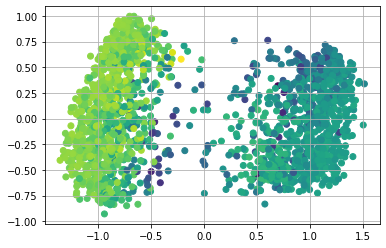

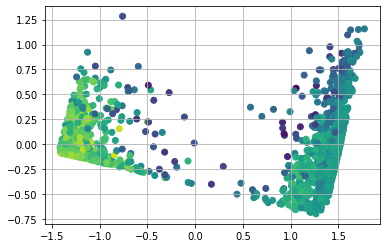

In [23]:
pca_all = PCA(n_components=2)

for frame_index in range(len(df_all)-2):
    plt.figure()
    df_array = np.array(df_all_agglo[frame_index])
    pca_all.fit(df_array)
    feat_mat_tf = pca_all.transform(df_array)
    plt.grid()
    plt.scatter(feat_mat_tf[:,0], feat_mat_tf[:,1], c=df_all[3][0])

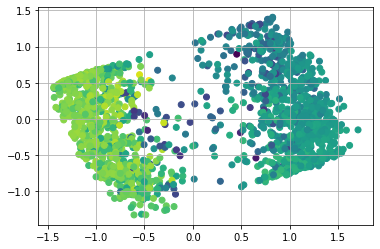

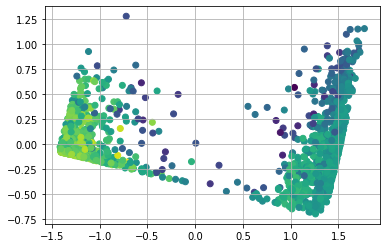

In [24]:
pca_all = PCA(n_components=2)

for frame_index in range(len(df_all)-2):
    plt.figure()
    df_array = np.array(df_all_ko_agglo[frame_index])
    pca_all.fit(df_array)
    feat_mat_tf = pca_all.transform(df_array)
    plt.grid()
    plt.scatter(feat_mat_tf[:,0], feat_mat_tf[:,1], c=df_all[3][0])

In [25]:
top_activations = {}
index_to_layer_name = dict(zip(range(len(number_of_agglo_feats)),
                              probe_layers[0:3]))
for frame_index in range(len(df_all)-1):
    X_var = np.array(df_all[frame_index])

    top_activations[index_to_layer_name[frame_index]] = np.sum(X_var,axis = 0).argsort()[-number_of_agglo_feats[frame_index]:][::-1]

# for layer in probe_layers:
#     if layer == 'classifier_2':
#         break
#     X_var = np.array(act_[layer].cpu())
#     top_activations[layer] = np.sum(X_var,axis = 0).argsort()[-number_of_agglo_feats[layer_name_to_index[layer]]:][::-1]

df_top_act = []
for frame_index in range(len(df_all)-1):
    df_top_act.append(df_all[frame_index][top_activations[probe_layers[frame_index]]])

In [32]:
no_k_component = 3

df_array_0 = np.array(df_all_ko_agglo[0])
df_array_1 = np.array(df_all_ko_agglo[1])
# df_array_2 = np.array(df_all_ko_agglo[2])

# df_array = np.array(df_all[1])
# top_mat = df_array
# gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
# gmm.fit(top_mat)
# gmm_label_all_1 = gmm.predict(top_mat)

df_array = np.array(df_all_agglo[1])
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_all_agglo_1 = gmm.predict(top_mat)

# df_array = np.array(df_all_ko[1])
# top_mat = df_array
# gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
# gmm.fit(top_mat)
# gmm_label_ko_1 = gmm.predict(top_mat)

df_array = np.array(df_all_ko_agglo[1])
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_ko_allgo_1 = gmm.predict(top_mat)

# df_array = np.concatenate((df_array_0, df_array_1), axis=1)
# top_mat = df_array
# gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
# gmm.fit(top_mat)
# gmm_label_combine_1 = gmm.predict(top_mat)

df_array = np.array(df_top_act[1])
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_top_act_1 = gmm.predict(top_mat)

In [33]:
digit_label = pd.DataFrame(data=np.array(y_.cpu()))[df_c2['pred'] == 0]

In [34]:
# score_act_1 = np.asarray([np.count_nonzero(gmm_label_top_act_1==c)*drv.entropy(np.array(y_[gmm_label_top_act_1==c])) for c in range(no_k_component)])
# score_all_1 = np.asarray([np.count_nonzero(gmm_label_all_1==c)*drv.entropy(np.array(y_[gmm_label_all_1==c])) for c in range(no_k_component)])
# score_ko_1 = np.asarray([np.count_nonzero(gmm_label_ko_1==c)*drv.entropy(np.array(y_[gmm_label_ko_1==c])) for c in range(no_k_component)])
# score_ko_agglo_1 = np.asarray([np.count_nonzero(gmm_label_ko_allgo_1 ==c)*drv.entropy(np.array(y_[gmm_label_ko_allgo_1==c])) for c in range(no_k_component)])
# score_ko_agglo_combine_1 = np.asarray([np.count_nonzero(gmm_label_combine_1==c)*drv.entropy(np.array(y_[gmm_label_combine_1==c])) for c in range(no_k_component)])

digit_label = pd.DataFrame(data=np.array(y_.cpu()))[df_c2['pred'] == 0]

score_act_1 =              np.asarray([drv.entropy(np.array(digit_label[gmm_label_top_act_1==c][0])) for c in range(no_k_component)])
# score_all_1 =              np.asarray([drv.entropy(np.array(digit_label[gmm_label_all_1==c][0])) for c in range(no_k_component)])
score_all_agglo_1 =        np.asarray([drv.entropy(np.array(digit_label[gmm_label_all_agglo_1==c][0])) for c in range(no_k_component)])
# score_ko_1 =               np.asarray([drv.entropy(np.array(digit_label[gmm_label_ko_1==c][0])) for c in range(no_k_component)])
score_ko_agglo_1 =         np.asarray([drv.entropy(np.array(digit_label[gmm_label_ko_allgo_1==c][0])) for c in range(no_k_component)])
# score_ko_agglo_combine_1 = np.asarray([drv.entropy(np.array(digit_label[gmm_label_combine_1==c][0])) for c in range(no_k_component)])

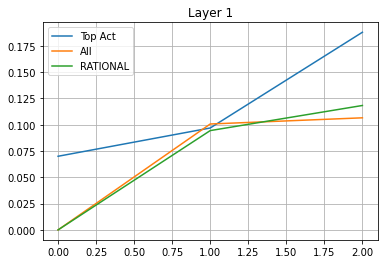

In [35]:
fig = plt.figure()

plt.plot(np.sort(score_act_1))
plt.plot(np.sort(score_all_agglo_1))
plt.plot(np.sort(score_ko_agglo_1))

plt.grid()
plt.title("Layer " + str(1))
plt.legend(["Top Act", "All", "RATIONAL"])

In [36]:
df_array_0 = np.array(df_all_ko_agglo[0])
df_array_1 = np.array(df_all_ko_agglo[1])
# df_array_2 = np.array(df_all_ko_agglo[2])

# df_array = np.array(df_all[1])
# top_mat = df_array
# gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
# gmm.fit(top_mat)
# gmm_label_all_1 = gmm.predict(top_mat)

df_array = np.array(df_all_agglo[0])
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_all_agglo_0 = gmm.predict(top_mat)

# df_array = np.array(df_all_ko[1])
# top_mat = df_array
# gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
# gmm.fit(top_mat)
# gmm_label_ko_1 = gmm.predict(top_mat)

df_array = np.array(df_all_ko_agglo[0])
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_ko_allgo_0 = gmm.predict(top_mat)

# df_array = np.concatenate((df_array_0, df_array_1), axis=1)
# top_mat = df_array
# gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
# gmm.fit(top_mat)
# gmm_label_combine_1 = gmm.predict(top_mat)

df_array = np.array(df_top_act[0])
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_top_act_0 = gmm.predict(top_mat)

In [37]:
score_act_0 =              np.asarray([drv.entropy(np.array(digit_label[gmm_label_top_act_0==c][0])) for c in range(no_k_component)])
score_all_agglo_0 =        np.asarray([drv.entropy(np.array(digit_label[gmm_label_all_agglo_0==c][0])) for c in range(no_k_component)])
score_ko_agglo_0 =         np.asarray([drv.entropy(np.array(digit_label[gmm_label_ko_allgo_0==c][0])) for c in range(no_k_component)])


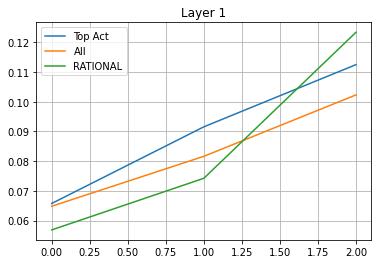

In [38]:
fig = plt.figure()

plt.plot(np.sort(score_act_0))
plt.plot(np.sort(score_all_agglo_0))
plt.plot(np.sort(score_ko_agglo_0))

plt.grid()
plt.title("Layer " + str(1))
plt.legend(["Top Act", "All", "RATIONAL"])

In [39]:
# combine

df_array_0 = np.array(df_all_ko_agglo[0])
df_array_1 = np.array(df_all_ko_agglo[1])
# df_array_2 = np.array(df_all_ko_agglo[2])

df_array = np.concatenate((df_array_0, df_array_1), axis=1)
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_ko_agglo_combine = gmm.predict(top_mat)

df_array_0 = np.array(df_top_act[0])
df_array_1 = np.array(df_top_act[1])
# df_array_2 = np.array(df_top_act[2])

df_array = np.concatenate((df_array_0, df_array_1), axis=1)
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_top_act_combine = gmm.predict(top_mat)

df_array_0 = np.array(df_all_agglo[0])
df_array_1 = np.array(df_all_agglo[1])
# df_array_2 = np.array(df_all_agglo[2])

df_array = np.concatenate((df_array_0, df_array_1), axis=1)
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_all_agglo_combine = gmm.predict(top_mat)

In [40]:
# score_act_combine = np.asarray([drv.entropy(np.array(y_[gmm_label_top_act_combine==c])) for c in range(no_k_component)])
# score_all_combine = np.asarray([drv.entropy(np.array(y_[gmm_label_all_agglo_combine==c])) for c in range(no_k_component)])
# score_ko_combine = np.asarray([drv.entropy(np.array(y_[gmm_label_ko_agglo_combine==c])) for c in range(no_k_component)])

score_act_combine =              np.asarray([drv.entropy(np.array(digit_label[gmm_label_top_act_combine==c][0])) for c in range(no_k_component)])
score_all_agglo_combine =        np.asarray([drv.entropy(np.array(digit_label[gmm_label_all_agglo_combine==c][0])) for c in range(no_k_component)])
score_ko_agglo_combine =         np.asarray([drv.entropy(np.array(digit_label[gmm_label_ko_agglo_combine==c][0])) for c in range(no_k_component)])


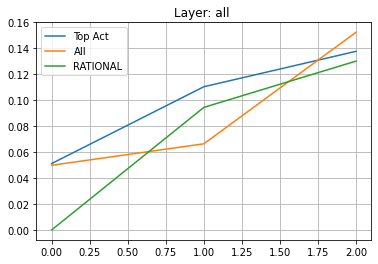

In [41]:
fig = plt.figure()

plt.plot(np.sort(score_act_combine))
plt.plot(np.sort(score_all_agglo_combine))
plt.plot(np.sort(score_ko_agglo_combine))

plt.grid()
plt.title("Layer: all ")
plt.legend(["Top Act", "All", "RATIONAL"])

(-6.475011229515076, 9.126901507377625, -8.036236572265626, 8.186287689208985)

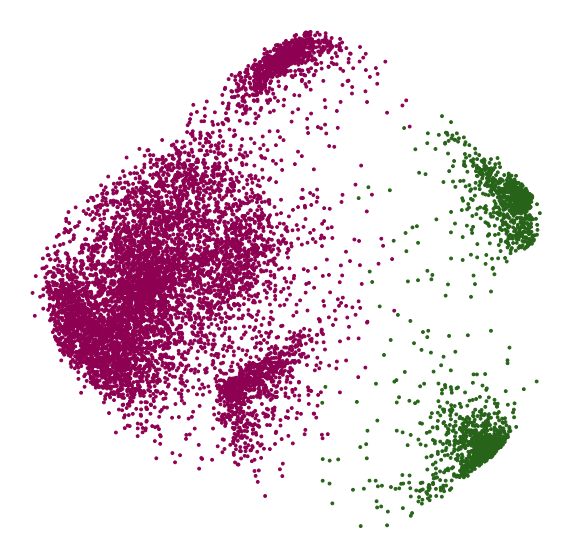

In [43]:
plt.figure(figsize=(10,10))
df_array = np.array(df_c1)
pca_all.fit(df_array)
feat_mat_tf = pca_all.transform(df_array)
# plt.grid()
plt.scatter(feat_mat_tf[:,0], feat_mat_tf[:,1], c=-df_c2['pred'], cmap = 'PiYG', s = 8)
plt.axis('off')
# plt.title('PCA of the last layer activations', fontsize = '26')
# filename = 'FDR_mod_2_digit.png'
# fig.savefig(filename, dpi=fig.dpi)

In [66]:
no_runs = 100
k_low = 1
k_high = 10

range_component = k_high - k_low

act_scores = np.zeros((no_runs,range_component))
all_scores = np.zeros((no_runs,range_component))
rational_scores = np.zeros((no_runs,range_component))

for i in range(no_runs):
    for no_component in range(range_component):
        no_k_component = no_component + k_low 
        df_array_0 = np.array(df_all_ko_agglo[0])
        df_array_1 = np.array(df_all_ko_agglo[1])

        df_array = np.concatenate((df_array_0, df_array_1), axis=1)
        top_mat = df_array
        gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
        gmm.fit(top_mat)
        gmm_label_ko_agglo_combine = gmm.predict(top_mat)

        df_array_0 = np.array(df_top_act[0])
        df_array_1 = np.array(df_top_act[1])

        df_array = np.concatenate((df_array_0, df_array_1), axis=1)
        top_mat = df_array
        gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
        gmm.fit(top_mat)
        gmm_label_top_act_combine = gmm.predict(top_mat)

        df_array_0 = np.array(df_all_agglo[0])
        df_array_1 = np.array(df_all_agglo[1])

        df_array = np.concatenate((df_array_0, df_array_1), axis=1)
        top_mat = df_array
        gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
        gmm.fit(top_mat)
        gmm_label_all_agglo_combine = gmm.predict(top_mat)

        score_act_combine =       np.asarray([drv.entropy(np.array(digit_label[gmm_label_top_act_combine==c][0])) for c in range(no_k_component)])
        score_all_agglo_combine = np.asarray([drv.entropy(np.array(digit_label[gmm_label_all_agglo_combine==c][0])) for c in range(no_k_component)])
        score_ko_agglo_combine =  np.asarray([drv.entropy(np.array(digit_label[gmm_label_ko_agglo_combine==c][0])) for c in range(no_k_component)])

        act_scores[i,no_component] = np.average(score_act_combine)
        all_scores[i,no_component] = np.average(score_all_agglo_combine)
        rational_scores[i,no_component] = np.average(score_ko_agglo_combine)

# act_scores = act_scores/(no_runs)
# all_scores = all_scores/(no_runs)
# rational_scores = rational_scores/(no_runs)


In [81]:
ave_act_score = np.zeros(range_component)
ave_all_score = np.zeros(range_component)
ave_rational_score = np.zeros(range_component)
ci_act_score = np.zeros(range_component)
ci_all_score = np.zeros(range_component)
ci_rational_score = np.zeros(range_component)

for no_component in range(range_component):
    ave_act_score[no_component] = np.average(act_scores[:,no_component])
    ci_act_score[no_component] = 1.96 * np.std(act_scores[:,no_component])/np.mean(act_scores[:,no_component])/100
    ave_all_score[no_component] = np.average(all_scores[:,no_component])
    ci_all_score[no_component] = 1.96 * np.std(all_scores[:,no_component])/np.mean(all_scores[:,no_component])/100
    ave_rational_score[no_component] = np.average(rational_scores[:,no_component])
    ci_rational_score[no_component] = 1.96 * np.std(rational_scores[:,no_component])/np.mean(rational_scores[:,no_component])/100

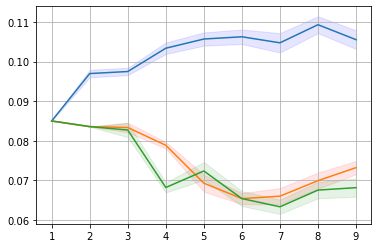

In [83]:
fig = plt.figure()

plt.grid()
plt.plot(range(k_low,k_high), ave_act_score)
plt.fill_between(range(k_low,k_high), (ave_act_score-ci_act_score), (ave_act_score+ci_act_score), color='b', alpha=.1)
plt.plot(range(k_low,k_high), ave_all_score)
plt.fill_between(range(k_low,k_high), (ave_all_score-ci_all_score), (ave_all_score+ci_all_score), color='r', alpha=.1)
plt.plot(range(k_low,k_high), ave_rational_score)
plt.fill_between(range(k_low,k_high), (ave_rational_score-ci_rational_score), (ave_rational_score+ci_rational_score), color='g', alpha=.1)

In [88]:
no_runs = 100
k_low = 1
k_high = 10

# range_component = k_high - k_low

no_component = 5
no_k_component = no_component + k_low 

act_runs = np.zeros((no_runs,no_k_component))
all_runs = np.zeros((no_runs,no_k_component))
rational_runs = np.zeros((no_runs,no_k_component))

for i in range(no_runs):
    df_array_0 = np.array(df_all_ko_agglo[0])
    df_array_1 = np.array(df_all_ko_agglo[1])

    df_array = np.concatenate((df_array_0, df_array_1), axis=1)
    top_mat = df_array
    gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
    gmm.fit(top_mat)
    gmm_label_ko_agglo_combine = gmm.predict(top_mat)

    df_array_0 = np.array(df_top_act[0])
    df_array_1 = np.array(df_top_act[1])

    df_array = np.concatenate((df_array_0, df_array_1), axis=1)
    top_mat = df_array
    gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
    gmm.fit(top_mat)
    gmm_label_top_act_combine = gmm.predict(top_mat)

    df_array_0 = np.array(df_all_agglo[0])
    df_array_1 = np.array(df_all_agglo[1])

    df_array = np.concatenate((df_array_0, df_array_1), axis=1)
    top_mat = df_array
    gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
    gmm.fit(top_mat)
    gmm_label_all_agglo_combine = gmm.predict(top_mat)

    score_act_combine =       np.asarray([drv.entropy(np.array(digit_label[gmm_label_top_act_combine==c][0])) for c in range(no_k_component)])
    score_all_agglo_combine = np.asarray([drv.entropy(np.array(digit_label[gmm_label_all_agglo_combine==c][0])) for c in range(no_k_component)])
    score_ko_agglo_combine =  np.asarray([drv.entropy(np.array(digit_label[gmm_label_ko_agglo_combine==c][0])) for c in range(no_k_component)])

    act_runs[i] = np.sort(score_act_combine)
    all_runs[i] = np.sort(score_all_agglo_combine)
    rational_runs[i] = np.sort(score_ko_agglo_combine)

# act_scores = act_scores/(no_runs)
# all_scores = all_scores/(no_runs)
# rational_scores = rational_scores/(no_runs)


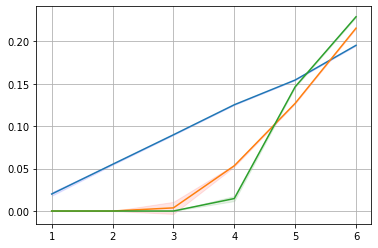

In [90]:
ave_act_run = np.zeros(no_k_component)
ave_all_run = np.zeros(no_k_component)
ave_rational_run = np.zeros(no_k_component)
ci_act_run = np.zeros(no_k_component)
ci_all_run = np.zeros(no_k_component)
ci_rational_run = np.zeros(no_k_component)

for no_component in range(no_k_component):
    ave_act_run[no_component] = np.average(act_runs[:,no_component])
    ci_act_run[no_component] = 1.96 * np.std(act_runs[:,no_component])/(np.mean(act_runs[:,no_component])+0.00001)/1000
    ave_all_run[no_component] = np.average(all_runs[:,no_component])
    ci_all_run[no_component] = 1.96 * np.std(all_runs[:,no_component])/(np.mean(all_runs[:,no_component])+0.00001)/1000
    ave_rational_run[no_component] = np.average(rational_runs[:,no_component])
    ci_rational_run[no_component] = 1.96 * np.std(rational_runs[:,no_component])/(np.mean(rational_runs[:,no_component])+0.00001)/1000


fig = plt.figure()

plt.grid()
plt.plot(range(1,no_k_component+1), ave_act_run)
plt.fill_between(range(1,no_k_component+1), (ave_act_run-ci_act_run), (ave_act_run+ci_act_run), color='b', alpha=.1)
plt.plot(range(1,no_k_component+1), ave_all_run)
plt.fill_between(range(1,no_k_component+1), (ave_all_run-ci_all_run), (ave_all_run+ci_all_run), color='r', alpha=.1)
plt.plot(range(1,no_k_component+1), ave_rational_run)
plt.fill_between(range(1,no_k_component+1), (ave_rational_run-ci_rational_run), (ave_rational_run+ci_rational_run), color='g', alpha=.1)